## Regression in Python

In [42]:
import pandas as pd
import math
import numpy as np
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns

from cancerolstools import preprocess as pp
from cancerolstools import ols as ls

np.random.seed(123456)

## Step 1: Preprocessing the Data

In this step, we will utilize the cancerolstools preprocess module along with some functions from the ols module to clean the data and make it suitable for linear modeling. Namely, we will start by applying the preprocessing steps detailed in the Data Preparation phase, and then apply a convenient technique to convert the names of states into integers for later convenience in the project.

In [43]:
fips_df = pp.import_fips()
cancer_df = pp.import_cancer()

In [44]:
cancer_df = pp.cancer_preprocess(cancer_df)

state_dict = ls.make_state_dict()

In [45]:
cancer_int_df = ls.cancer_int(cancer_df)

We begin our discussion by observing the percentage of values in each column that are recorded as NA. As linear regression will require some kind of value for these rows in order to generate a prediction, we will need to determine an appropriate method to impute heavily missing variables, and also diagnose if these variables are significant to the model.

In [46]:
moddat = cancer_int_df
(moddat.isna().mean())*100

avgAnnCount                 0.000000
avgDeathsPerYear            0.000000
TARGET_deathRate            0.000000
incidenceRate               0.000000
medIncome                   0.000000
popEst2015                  0.000000
povertyPercent              0.000000
studyPerCap                 0.000000
MedianAge                   0.000000
MedianAgeMale               0.000000
MedianAgeFemale             0.000000
AvgHouseholdSize            0.000000
PercentMarried              0.000000
PctNoHS18_24                0.000000
PctHS18_24                  0.000000
PctSomeCol18_24            74.991795
PctBachDeg18_24             0.000000
PctHS25_Over                0.000000
PctBachDeg25_Over           0.000000
PctEmployed16_Over          4.988513
PctUnemployed16_Over        0.000000
PctPrivateCoverage          0.000000
PctPrivateCoverageAlone    19.986872
PctEmpPrivCoverage          0.000000
PctPublicCoverage           0.000000
PctPublicCoverageAlone      0.000000
PctWhite                    0.000000
P

Since PctSomeCol18_24 has a NA rate of 74.99%, and represents the inbetween between high
school diploma and bachelors, we can justify excluding it.
PctEmployed16_Over has only a 4.99% NA rate, and PctPublicCoverageAlone, which is the
percentage of county residents with government-provided health coverage alone, has a 19.99%
NA rate, but seems too important to ignore if we wish to consider the status of coverage as a
variable(s).
Let us do MICE (Multiple Imputation by Chained Equations) to replace these NA values with
very likely substitutions. MICE operates under the assumption that the data missing is MAR
(Missing at Random).
Due to the data collection process (each row represents a county), the likely possible bias is
that certain states refuse or fail to collect these variables in a systematic way, and thus the
data is no longer MAR. We will check this assumption towards the end of the modelling by
considering our finalized model on both the imputated and original dataset (rows including
NA’s will be removed), and assess their similarities. Regardless, modelling will be done using
the imputed dataset, assuming MAR.

In [47]:
# Drop the 18th column from the dataframe
trim = moddat.drop(columns=['PctSomeCol18_24'])

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# create an instance of the imputer class
imputer = IterativeImputer(max_iter=50, random_state=0)

# fit the imputer on the data
imputer.fit(trim)

# impute the missing values
imputed_data = imputer.transform(trim)

# convert the imputed data to a pandas DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=trim.columns)

Initial variable selection for our model will be informed by domain knowledge and insight gained from prior visualization of the data.

Literature on socioeconomic factors affecting cancer mortality point to poverty, education, and race as some of the most important factors. In the 2017 paper "Socioeconomic and Racial/Ethnic Disparities in Cancer Mortality, Incidence, and Survival in the United States, 1950--2014: Over Six Decades of Changing Patterns and Widening Inequalities," the authors concluded that individuals in lower income and education groups had significantly higher mortality and incidence rates. The authors also noted that Blacks had significantly higher mortality and incidence rates than other races. In the 2021 paper "Leading cancers contributing to educational disparities in cancer mortality in the US, 2017," the authors concluded that there was a significant difference between the mortality rate between individuals with a bachelors degree and higher, and all education levels below that. Since both these studies use data exclusively from the U.S., and are within the the time frame of interest to us, we are comfortable using these conclusions to guide our variable selection.

The visualizations of our own data support these conclusions as well as suggest a categorical variable indicating whether a given county is in the Southwest region.

Additionally, the conclusions from the second paper suggest two new variables, **PctNoHS18_24** and **PctHS18_24**, which represent thepercent of county residents ages 18-24 whose highest education attained is less than a high school degree, and then a high school degree, respectively. While there are several other variables related to educational goals, such as percentage of county residents ages 18-24 who have attained a bachelors, the literature above suggests that residents with lower educational achievements have a higher cancer mortality, while the opposite is not necessarily true.

The variables for the initial model will be povertyPercent (Percent of populace in poverty), PctBlack, and PctNoHS18 and PctHS18_24. For future investigation we will consider isSouthEast (a categorical variable created later), as well as the variables related to healthcare coverage (**PctPrivateCoverage, PctPrivateCoverageAlone, PctEmpPrivCoverage, PctPublicCoverage, PctPubliceCoverageAlone).**



Firstly, let us examine the variables selected to see if any transformations would be appropriate.

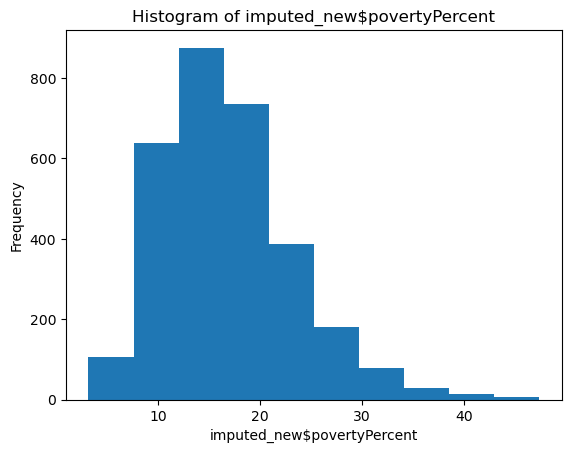

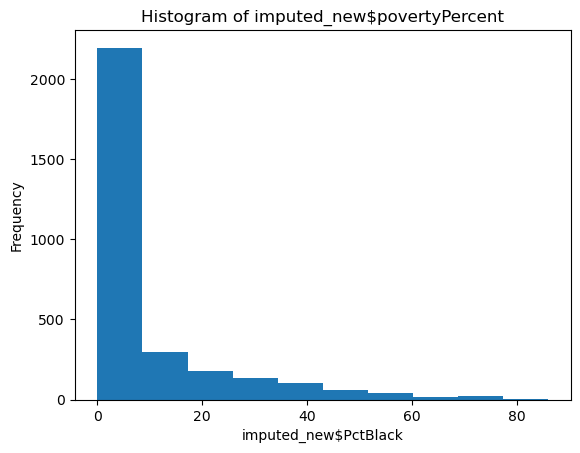

<Figure size 640x480 with 0 Axes>

In [48]:
imputed_new = imputed_df.copy() # create a copy of imputed
import matplotlib.pyplot as plt # import the matplotlib library for plotting

plt.hist(imputed_new['povertyPercent'])
plt.title('Histogram of imputed_new$povertyPercent')
plt.xlabel('imputed_new$povertyPercent')
plt.ylabel('Frequency')
plt.show()

plt.hist(imputed_new['PctBlack'])
plt.title('Histogram of imputed_new$povertyPercent')
plt.xlabel('imputed_new$PctBlack')
plt.ylabel('Frequency')
plt.show()
plt.savefig('figures/Poverty_Percent_Hist.png')

In [49]:
import sklearn.linear_model as lm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.ols(formula='TARGET_deathRate ~ povertyPercent + PctBlack + PctNoHS18_24 + PctHS18_24', data=imputed_new)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       TARGET_deathRate   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     240.4
Date:                Wed, 10 May 2023   Prob (F-statistic):          1.39e-179
Time:                        23:23:14   Log-Likelihood:                -14031.
No. Observations:                3047   AIC:                         2.807e+04
Df Residuals:                    3042   BIC:                         2.810e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        127.5873      2.110     60.

The initial fit is rather weak, with a R-squared of 0.24. Let us code and add isSoutheast as a categorical variable. To define which states belong to the Southeast, we will be using the regions specified by the Bureau of Economic Analysis, who divide the United States into 8 regions. Finally, we will use ANOVA to discern whether this suggested categorical variable is significant to our regression.

In [50]:
Southeast = ["Alabama", "Arkansas", "Florida", "Georgia", "Kentucky", "Louisiana", "Mississippi", "North Carolina", "South Carolina", "Tennessee", "Virginia", "West Virginia"]
Southeast_int = [state_dict[x] for x in Southeast]
Southeast_int

[1, 4, 9, 10, 17, 18, 24, 33, 40, 42, 46, 48]

In [51]:
imputed_new['isSoutheast'] = imputed_new['State'].isin(Southeast_int).astype(int)
imputed_new

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,...,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,Target_div_Income,State,Target_div_LogIncome,isSoutheast
0,1397.000000,469.0,164.9,489.800000,61898.0,260131.0,11.2,499.748204,39.3,36.9,...,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831,0.002664,47.0,14.945742,0
1,173.000000,70.0,161.3,411.600000,48127.0,43269.0,18.6,23.111234,33.0,32.2,...,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096,0.003352,47.0,14.960676,0
2,102.000000,50.0,174.7,349.700000,49348.0,21026.0,14.6,47.560164,45.0,44.0,...,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488,0.003540,47.0,16.165968,0
3,427.000000,202.0,194.8,430.400000,44243.0,75882.0,17.1,342.637253,42.8,42.2,...,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841,0.004403,47.0,18.209943,0
4,57.000000,26.0,144.4,350.100000,49955.0,10321.0,12.5,0.000000,48.3,47.8,...,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657,0.002891,47.0,13.347040,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1962.667684,15.0,149.6,453.549422,46961.0,6343.0,12.4,0.000000,44.2,41.1,...,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512,0.003186,16.0,13.907129,0
3043,1962.667684,43.0,150.1,453.549422,48609.0,37118.0,18.8,377.175494,30.4,29.3,...,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470,0.003088,16.0,13.909013,0
3044,1962.667684,46.0,153.9,453.549422,51144.0,34536.0,15.0,1968.959926,30.9,30.5,...,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192,0.003009,16.0,14.194274,0
3045,1962.667684,52.0,175.0,453.549422,50745.0,25609.0,13.3,0.000000,39.0,36.9,...,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938,0.003449,16.0,16.152005,0


In [52]:
model1 = smf.ols(formula='TARGET_deathRate ~ povertyPercent + PctBlack + PctNoHS18_24 + PctHS18_24 + isSoutheast', data=imputed_new)
result1 = model1.fit()

print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:       TARGET_deathRate   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     221.6
Date:                Wed, 10 May 2023   Prob (F-statistic):          4.65e-202
Time:                        23:23:14   Log-Likelihood:                -13976.
No. Observations:                3047   AIC:                         2.796e+04
Df Residuals:                    3041   BIC:                         2.800e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        130.1146      2.086     62.

## Step 2: Feature Selection using LASSO

To add variables of interest, we will be using Lasso regression using the minimum residual deviance Lambda value, which will be obtained using cross-validation. 

In [53]:
from sklearn.linear_model import LassoCV


y = imputed_new['TARGET_deathRate']
x = imputed_new[['povertyPercent', 'PctBlack', 'PctHS18_24',
                 'PctNoHS18_24', 'isSoutheast','PctPublicCoverage',
                 'PctPublicCoverageAlone', "PctUnemployed16_Over"]]

modelcvalpha = LassoCV(alphas = None, cv = 10, max_iter = 100000).fit(x, y)

alpha = getattr(modelcvalpha, 'alpha_')
alpha

0.1036378151764025

In [54]:
newmodel = lm.Lasso(alpha=alpha)
newmodel = newmodel.fit(x, y)

coefs = getattr(newmodel, 'coef_')
print('original alpha coefficients:', coefs)

med_penalty = lm.Lasso(alpha=alpha * 10)
med_penalty = med_penalty.fit(x, y)

coefs2 = getattr(med_penalty, 'coef_')
print('medium penalty alpha coefficients:', coefs2)

big_penalty = lm.Lasso(alpha=2.1288)
big_penalty = big_penalty.fit(x, y)

coefs3 = getattr(big_penalty, 'coef_')
print('large penalty alpha coefficients:', coefs3)

original alpha coefficients: [ 6.18181993e-01  6.51711241e-04  4.98726850e-01 -1.89012910e-01
  1.07662463e+01  3.04999629e-01  6.05695117e-01  5.43496705e-01]
medium penalty alpha coefficients: [ 0.68629493  0.09569364  0.53236952 -0.20267754  4.6051785   0.30719053
  0.61788852  0.50146913]
large penalty alpha coefficients: [ 0.73507278  0.1688434   0.5539995  -0.20376628  0.          0.30902248
  0.62794433  0.43131725]


Based on the result of the optimal LASSO regression using the alpha value of 0.103 that minimizes residual deviance using the LassoCV function, we observe that none of the coefficients are in fact regularized out of the model. In fact, even with an alpha hyperparameter of 10 times the optimal alpha value, still no covariates are removed from the model. From what we can see, it seems that the 2nd covariate, 'PctBlack', is the most close to 0 in both cases. We will investigate the statistical significance of these variables more closely in the following section, bootstrapping, but it is interesting to realize that even by applying the canonical LASSO method which should tend to regularize out covariates and give a more parsimonious model, we need to employ quite a larger hyperparameter to realize the effect of shrinkage.

We note that in the original R analysis from which this project is based using the glmnet package, the lambda value that reaches 1 standard error away from the minimum is 2.1288. For comparison's sake, we implement this alpha value as well to determine if shrinkage occurs. Indeed we see that the 5th covariate, 'isSoutheast', has been removed from the model as opposed to simply the covariate with the smallest magnitude.

What we can determine from these results is ultimately sparse, as there was no consistent pattern seeing as only 1 coefficient was selected out of the model. While feature selection has indeed occurred using the larger alpha value, it is not certain to see that this necessarily generates the best model, or that the 'isSoutheast' is the worst feature. This motivates our second point of analysis, which relaxes the assumptions of linear modeling, which is the nonparametric bootstrap method of generating confidence intervals for different parameters.

## Step 3: Statistical Inference using Nonparametric Bootstrap

We apply a nonparametric bootstrap approach to determine the statistical significance of the various parameters involved in the imputed dataset. This will relax the assumptions of the linear modeling, specifically the assumption of normally distributed errors, and allow us to visualize the distributions of these coefficients.

In [55]:
povertyPercent = []
PctHS18_24 = []
isSoutheast = []
PctPublicCoverage = []
PctPublicCoverageAlone = []
PctUnemployed16_Over = []

for i in range(1000):
    bootparams = ls.bootstrap_model(imputed_new)
    povertyPercent += [bootparams[0]]
    PctHS18_24 += [bootparams[1]]
    isSoutheast += [bootparams[2]]
    PctPublicCoverage += [bootparams[3]]
    PctPublicCoverageAlone += [bootparams[4]]
    PctUnemployed16_Over += [bootparams[5]]
    
orig_params = smf.ols(formula="TARGET_deathRate ~ povertyPercent + PctHS18_24 + isSoutheast + PctPublicCoverage + PctPublicCoverageAlone + PctUnemployed16_Over", data=imputed_new).fit().params[1:]


The above code utilizes the function `bootstrap_model` from the ols module of the cancerolstools package, which conducts a nonparametric bootstrap on given data and extracts linear regression coefficients. We additionally locate the original parameters on the original sample for comparison.

In [56]:
#make df of results

bootdf = pd.DataFrame({'povertyPercent': povertyPercent,
                       'PctHS18_24': PctHS18_24,
                       'isSoutheast': isSoutheast,
                       'PctPublicCoverage': PctPublicCoverage,
                       'PctPublicCoverageAlone': PctPublicCoverageAlone,
                       'PctUnemployed16_Over': PctUnemployed16_Over})

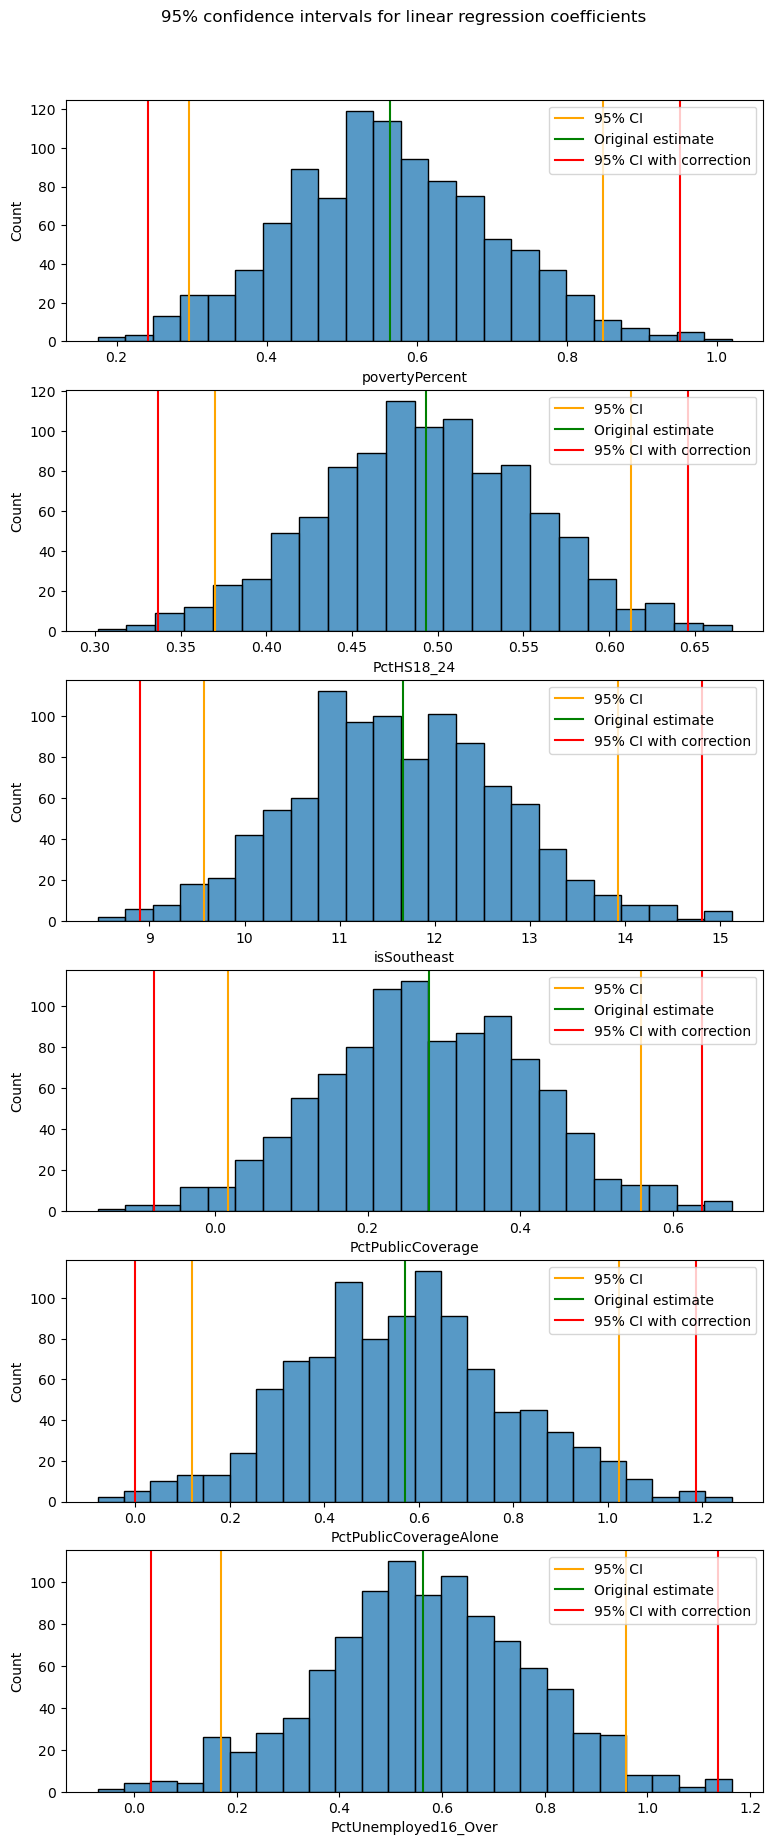

In [59]:
# plot SBS hists of vars in df

fig, axs = plt.subplots(6, 1, figsize=(9, 9))
plt.subplots_adjust(bottom=-1)

for i in range(len(bootdf.columns)):
    axs[i].axvline(x=np.percentile(bootdf[bootdf.columns[i]], 2.5), color='orange', label='95% CI')
    axs[i].axvline(x=np.percentile(bootdf[bootdf.columns[i]], 97.5), color='orange')
    axs[i].axvline(x=orig_params[i], color='green', label='Original estimate')
    axs[i].axvline(x=np.percentile(bootdf[bootdf.columns[i]], 2.5/6), color='red', label='95% CI with correction')
    axs[i].axvline(x=np.percentile(bootdf[bootdf.columns[i]], 100-(2.5/6)), color='red')
    sns.histplot(data=bootdf, x=str(bootdf.columns[i]), ax=axs[i])
    axs[i].legend()
    
plt.suptitle('95% confidence intervals for linear regression coefficients')
plt.savefig('figures/Confidence_Interval_Hist.png')

We employ a Bonferroni correction (in red) to account for the simultaneous construction of 6 confidence intervals and 6 hypothesis tests.

From initial inspection, it’s clear that povertyPercent, PctHS18_24, and isSoutheastYes
all reject the null hypothesis that the respective coefficient effect is actually 0. Upon inspecting
PctUnemployed16_Over’s bottom quantile, it appears this variable rejects
the null hypothesis that the respective coefficient effect is actually 0. PctPublicCoverage and
PctPublicCoverageAlone both fail to reject the hypothesis that the coefficient effect is actually 0 if a Bonferroni correction is applied.

Based on these inference results, each of the variables with a confidence interval that doesn’t
include 0 does have some effect on cancer mortality, while we cannot for certain say the same for
PctPublicCoverage and PctPublicCoverageAlone, whose confidence interval does contain 0.
These conclusions of course are contingent on confidence level selected (0.05 with a Bonferroni
Correction), the randomness of the Bootstrap (1000 replications), as well as the randomness of
the imputation process. Using a random seed, we provide just 1 realization of the results.

## Step 4: Conclusion of the Model

In [58]:
orig_params_model = smf.ols(formula="TARGET_deathRate ~ povertyPercent + PctHS18_24 + isSoutheast + PctPublicCoverage + PctPublicCoverageAlone + PctUnemployed16_Over", data=imputed_new).fit()
print(orig_params_model.summary())

                            OLS Regression Results                            
Dep. Variable:       TARGET_deathRate   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     203.5
Date:                Wed, 10 May 2023   Prob (F-statistic):          1.15e-218
Time:                        23:23:31   Log-Likelihood:                -13935.
No. Observations:                3047   AIC:                         2.788e+04
Df Residuals:                    3040   BIC:                         2.793e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                122

Based on the results of my modeling using Lasso regression and Bootstrap inference, we
came to the following conclusions to the research question. 

For every percent increase of a county's population in poverty, on average the cancer mortality per 100,000 residents in a county increases by approximately 0.563 individuals (CI: 0.2000-0.9467). For every percent increase of county residents ages 18-24 who’s highest education attained is a high school diploma, on average the cancer mortality per 100,000 residents increases by 0.4931 (CI: 0.3419-0.6497).

Compared to other regions of the United States, Southeast counties have on average 11.66 (CI:
8.642-14.6664) more cancer deaths per 100,000 residents. For every percent increase of county
residents with government-provided health coverage, on average the cancer mortality per 100,000 residents in a county increases by approximately 0.2811 individuals (CI: -0.06139 -0.6253). 

For every percent increase of county residents with government-provided health coverage alone, on average the cancer mortality per 100,000 residents in a county increases by approximately 0.5704 individuals (CI: -0.00614-1.1627). Finally, for every percent increase of county residents ages 16 and over unemployed, on average the cancer mortality per 100,000 residents in a county increases by approximately 0.563 individuals (CI: 0.0119-1.1144).


From these conclusions, the most important finding is that counties in the Southeast
region of the United States have significantly higher cancer mortality than other regions of the
United States. It is important to note that these conclusions have some limitations, including the
fact that the data ends at 2016 and only includes deaths from lung cancer, and that the modeling
assumes no excessive collinearity and utilizes techniques such as Lasso or Bootstrapping, which
have an aspect of randomness. Regardless, from these conclusions we would suggest further
research on specifically the Southeast region of the United States, to better understand the
specific causes of such higher mortality rates. Additionally, based on the results, education and
poverty were identified as significant predictors of cancer mortality, suggesting a few areas of
focus to start research on. Overall, the results highlight the need for federal action to aid these
Southeast communities, which in turn will reduce cancer mortality overall in the United States.